# DeepFake Detection

### 1 - Imports and Configurations

In [11]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import kaggle
import time
import copy

# Set Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Reproducibility (Crucial for comparing models fairness)
SEED = 42
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

# Global Config
DATASET_NAME = "ayushmandatta1/deepdetect-2025" 
DOWNLOAD_ROOT = "./deepdetect_data"
BATCH_SIZE = 32
NUM_WORKERS = 2 # Adjust based on OS (0 for Windows if issues arise)

Using device: cuda


### 2 - Data Donwload & Path Setup

In [12]:
# 1. Download Dataset
if not os.path.exists(DOWNLOAD_ROOT):
    print(f"Downloading {DATASET_NAME}...")
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files(DATASET_NAME, path=DOWNLOAD_ROOT, unzip=True)
    print("Download complete.")
else:
    print("Dataset already downloaded.")

# 2. Locate Folders
def find_folder(root_dir, target_name):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if target_name in dirnames:
            return os.path.join(dirpath, target_name)
    raise FileNotFoundError(f"Could not find folder '{target_name}' inside {root_dir}")

try:
    TRAIN_DIR_RAW = find_folder(DOWNLOAD_ROOT, 'train')
    TEST_DIR_RAW = find_folder(DOWNLOAD_ROOT, 'test') # We will strictly hold this out
    print(f"Training Root: {TRAIN_DIR_RAW}")
    print(f"Test (Holdout) Root:  {TEST_DIR_RAW}")
except FileNotFoundError as e:
    print(f"Error: {e}")

Dataset already downloaded.
Training Root: ./deepdetect_data\ddata\train
Test (Holdout) Root:  ./deepdetect_data\ddata\test


### 3 - Transformations

In [13]:
# Normalization stats from ImageNet (standard for transfer learning)
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

def get_transforms(img_size=224):
    """
    Returns a tuple of (aug_transforms, basic_transforms)
    """
    # 1. Strong Augmentation (For Training Optimized Models)
    aug_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ])

    # 2. Basic Transforms (For Validation, Testing, and Baseline Training)
    basic_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    ])
    
    return aug_transforms, basic_transforms

### 4 - Data Splitting & Loaders

In [14]:
def get_data_loaders(model_img_size=224, use_augmentation=False):
    """
    Creates dataloaders with the 'Test-Split Strategy' to avoid leakage.
    
    1. TRAIN: Uses ALL data in the 'train' folder (since old split was leaked).
       - Applies 'aug_transforms' if use_augmentation=True.
       
    2. VAL:  Steals 50% of the 'test' folder.
       - Used for checking progress and Early Stopping.
       - Always uses 'basic_transforms'.
       
    3. TEST: Keeps 50% of the 'test' folder.
       - Used ONLY for final evaluation.
       - Always uses 'basic_transforms'.
    """
    aug_tf, basic_tf = get_transforms(model_img_size)
    
    # --- 1. SETUP TRAINING DATA ---
    # We use the ENTIRE train folder for training.
    # We do NOT split this folder because of the filename/leakage issues.
    train_tf = aug_tf if use_augmentation else basic_tf
    train_dataset = datasets.ImageFolder(root=TRAIN_DIR_RAW, transform=train_tf)
    
    # --- 2. SETUP VALIDATION & TEST DATA ---
    # We load the 'test' folder (which we verified is clean/hard data)
    full_clean_dataset = datasets.ImageFolder(root=TEST_DIR_RAW, transform=basic_tf)
    
    # Calculate split sizes (50% Val, 50% Test)
    total_clean_count = len(full_clean_dataset)
    val_size = int(total_clean_count * 0.5)
    test_size = total_clean_count - val_size
    
    # Create the split using a fixed generator for reproducibility
    # This ensures Val and Test contain the SAME images every time you run the code
    val_subset, test_subset = torch.utils.data.random_split(
        full_clean_dataset, 
        [val_size, test_size],
        generator=torch.Generator().manual_seed(SEED)
    )
    
    # --- 3. CREATE LOADERS ---
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader   = DataLoader(val_subset,    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    test_loader  = DataLoader(test_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    print(f"Train samples:   {len(train_dataset)} (Used for learning weights)")
    print(f"Val samples:   {len(val_subset)}   (Used for tuning/stopping)")
    print(f"Test samples:   {len(test_subset)}   (Used for final metric)")
    
    return train_loader, val_loader, test_loader, train_dataset.classes

### 5 - Training

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler=None, num_epochs=10, patience=3, device=DEVICE,
                model_name="best_model"):
    
    since = time.time()

    # History tracking
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    
    print(f"Starting training for {model_name}...")

    for epoch in range(num_epochs):
        epoch_start = time.time() # Start Timer
        
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        
        # Convert tensor to float for history storage
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # --- VALIDATION PHASE ---
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)
        
        val_loss = val_running_loss / val_total_samples
        val_acc = val_running_corrects.double() / val_total_samples
        
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # --- END OF EPOCH LOGIC ---
        epoch_duration = time.time() - epoch_start
        
        # Step the scheduler if provided
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # --- PRINTING (History is preserved) ---
        print(f"Epoch {epoch+1}/{num_epochs} ({epoch_duration:.1f}s) - "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # --- EARLY STOPPING CHECK ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{model_name}.pth")
            patience_counter = 0
            print(f"--> Best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"--> EarlyStopping counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
                
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_val_acc:.4f}')

    # --- PLOTTING (Done once at the end) ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss Plot
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title(f'{model_name} Loss')
    ax[0].legend()
    ax[0].grid(True)
    
    # Acc Plot
    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title(f'{model_name} Accuracy')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

    model.load_state_dict(best_model_wts)
    return model, history

In [5]:
def train_smart_strategy(model, train_loader, val_loader, 
                         model_name="Optimized_Model", 
                         warmup_epochs=3, 
                         finetune_epochs=12,
                         patience=3):
    
    # --- 1. SETUP ---
    total_epochs = warmup_epochs + finetune_epochs
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # History tracking
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # DETECT ARCHITECTURE
    is_resnet = hasattr(model, 'fc') # True if ResNet
    print(f"🚀 Starting Smart Training for {model_name}")
    print(f"Architecture detected: {'ResNet (using .fc)' if is_resnet else 'EfficientNet/VGG (using .classifier)'}")

    # --- 2. PHASE 1: WARMUP (Head Only) ---
    print(f"\n=== PHASE 1: WARMUP (Head Only) ===")
    
    # Freeze everything first
    for param in model.parameters():
        param.requires_grad = False
        
    # Unfreeze Head based on architecture
    if is_resnet:
        for param in model.fc.parameters(): param.requires_grad = True
        head_params = model.fc.parameters()
    else:
        for param in model.classifier.parameters(): param.requires_grad = True
        head_params = model.classifier.parameters()
        
    # Optimizer 1: High LR for Head
    optimizer = optim.Adam(head_params, lr=1e-3)

    # --- MASTER LOOP ---
    for epoch in range(total_epochs):
        
        # [CRITICAL SWITCH]
        if epoch == warmup_epochs:
            print(f"\n=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===")
																					 
            
            backbone_params = []
            
            if is_resnet:
                # ResNet: Unfreeze Layer 3 and Layer 4
                # for param in model.layer3.parameters(): param.requires_grad = True
                for param in model.layer4.parameters(): param.requires_grad = True
                # list(model.layer3.parameters()) 
                backbone_params =  list(model.layer4.parameters())
            else:
                # EfficientNet: Unfreeze last 2 blocks of features
                for param in model.features[-2:].parameters(): param.requires_grad = True
                backbone_params = model.features[-2:].parameters()
            
            # SWITCH OPTIMIZER
            optimizer = optim.Adam([
                {'params': backbone_params, 'lr': 1e-4}, # Low LR for Body
                {'params': head_params,     'lr': 1e-3}  # High LR for Head
            ], weight_decay=1e-4)
            
            # Patience=1 for aggressive scheduling
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=1
            )

        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += inputs.size(0)
            
        epoch_loss = running_loss / total
        epoch_acc = correct.double() / total
        
        # --- VALIDATE ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_total += inputs.size(0)
                
        val_loss = val_loss / val_total
        val_acc = val_correct.double() / val_total
        
        # Save History
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())
        
        if epoch >= warmup_epochs:
            scheduler.step(val_acc)
        
        # --- PRINTING ---
        print(f"Epoch [{epoch+1}/{total_epochs}] "
              f"Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")
        
        # Best Model Save
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{model_name}.pth")
            patience_counter = 0 
        else:
            if epoch >= warmup_epochs:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at Epoch {epoch+1}")
                    break

    # --- PLOT ONCE AT THE END ---
    print(f"\nTraining Complete. Best Val Acc: {best_val_acc:.4f}")
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title(f'{model_name} Loss')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title(f'{model_name} Accuracy')
    ax[1].legend()
    ax[1].grid(True)
    plt.show()

    model.load_state_dict(best_model_wts)
    return model, history

### Model 1: Baseline EfficientNet B0

Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
Initializing Baseline EfficientNet B0...
Starting training for Baseline_B0...
Epoch 1/10 (296.9s) - Train Loss: 0.0834 Acc: 0.9678 | Val Loss: 1.0153 Acc: 0.7080
--> Best model saved! (Val Loss: 1.0153)
Epoch 2/10 (294.6s) - Train Loss: 0.0303 Acc: 0.9889 | Val Loss: 1.7282 Acc: 0.6124
--> EarlyStopping counter: 1/3
Epoch 3/10 (294.0s) - Train Loss: 0.0220 Acc: 0.9923 | Val Loss: 1.0716 Acc: 0.6961
--> EarlyStopping counter: 2/3
Epoch 4/10 (294.2s) - Train Loss: 0.0187 Acc: 0.9936 | Val Loss: 1.5399 Acc: 0.5414
--> EarlyStopping counter: 3/3
Early stopping triggered.
Training complete in 19m 40s
Best Val Acc: 0.7080


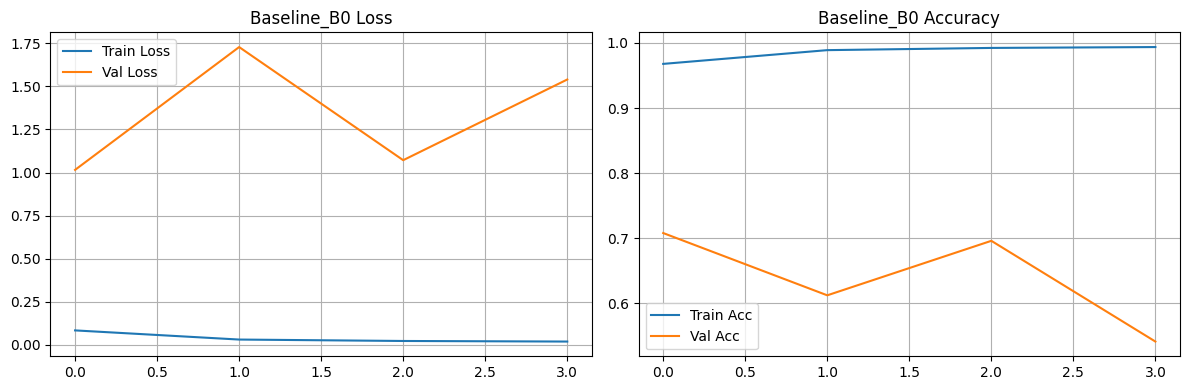

In [9]:
# --- MODEL 1: BASELINE EFFICIENTNET B0 ---

# 1. Data Loading (NO Augmentation for Baseline)
# We strictly use basic_transforms here to simulate a naive training setup.
train_loader_base, val_loader_base, _, classes = get_data_loaders(model_img_size=224, use_augmentation=False)

# 2. Model Setup
print("Initializing Baseline EfficientNet B0...")
model_b0_base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Naive Transfer Learning:
# We do NOT freeze weights. We train the entire network (backbone + head) from start.
# This often leads to overfitting on small datasets as we destroy ImageNet weights too fast.
for param in model_b0_base.parameters():
    param.requires_grad = True 

# Simple Head (No Dropout)
num_features = model_b0_base.classifier[1].in_features
model_b0_base.classifier[1] = nn.Linear(num_features, 2)
model_b0_base = model_b0_base.to(DEVICE)

# 3. Training Config (Standard)
criterion = nn.CrossEntropyLoss() # Standard Hard Loss
optimizer = optim.Adam(model_b0_base.parameters(), lr=0.001) # Standard Adam

# 4. Execution
model_b0_base, hist_b0_base = train_model(
    model_b0_base, 
    train_loader_base, 
    val_loader_base, 
    criterion, 
    optimizer,
    scheduler=None, # No scheduler for baseline
    num_epochs=10, 
    patience=3, 
    model_name="Baseline_B0"
)

### Model 2: Optimized EfficientNet B0

Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
Initializing Optimized EfficientNet B0...
🚀 Starting Smart Training: 3 Warmup + 12 Finetune

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.6872 | Val Acc: 0.8288 | Val Loss: 0.4906
Epoch [2/15] Train Acc: 0.6927 | Val Acc: 0.7797 | Val Loss: 0.5396
Epoch [3/15] Train Acc: 0.6911 | Val Acc: 0.8271 | Val Loss: 0.4936

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.7842 | Val Acc: 0.8893 | Val Loss: 0.3962
Epoch [5/15] Train Acc: 0.8402 | Val Acc: 0.8899 | Val Loss: 0.3934
Epoch [6/15] Train Acc: 0.8606 | Val Acc: 0.8844 | Val Loss: 0.3997
Epoch [7/15] Train Acc: 0.8726 | Val Acc: 0.9025 | Val Loss: 0.3781
Epoch [8/15] Train Acc: 0.8844 | Val Acc: 0.8787 | Val Loss: 0.4265
Epoch [9/15] Train Acc: 0.8935 | Val Acc: 0.8842 | Val Loss: 0.4148
Epoch [10/15] Train Acc: 0.9054 | Val Acc: 0.8926 | Val Lo

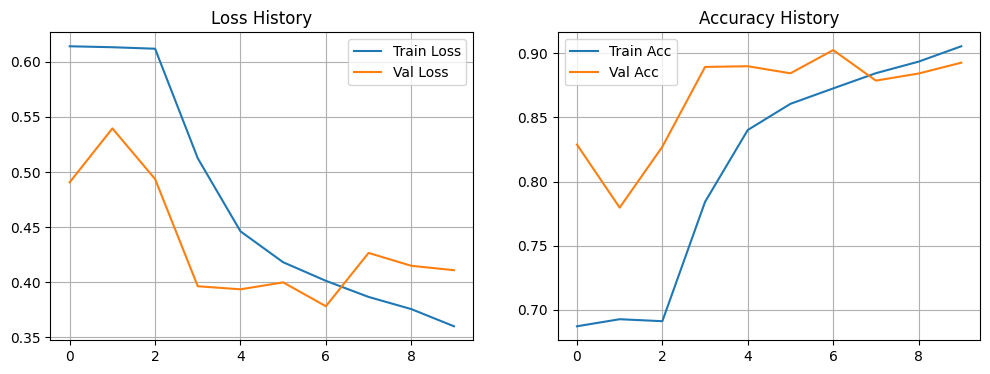

In [8]:
# --- MODEL 2: OPTIMIZED EFFICIENTNET B0 ---

# 1. Data (Standard 224x224 for B0)
train_loader_opt, val_loader_opt, _, _ = get_data_loaders(model_img_size=224, use_augmentation=True)

# 2. Model Setup
print("Initializing Optimized EfficientNet B0...")
model_b0_opt = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Robust Head Structure
num_features = model_b0_opt.classifier[1].in_features
model_b0_opt.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 2)
)
model_b0_opt = model_b0_opt.to(DEVICE)

# 3. Execution (Using the Smart Strategy)
# This will now:
#   1. Train ONLY the head for 3 epochs (Warmup)
#   2. Unfreeze the last 2 blocks and train for 12 more epochs (Fine-tuning)
model_b0_opt, hist_b0_opt = train_smart_strategy(
    model_b0_opt, 
    train_loader_opt, 
    val_loader_opt, 
    model_name="Optimized_B0",
    warmup_epochs=3,
    finetune_epochs=12,
    patience=3
)

### Model 3: Optimized EfficientNet B2

Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
Initializing EfficientNet B2...
🚀 Starting Smart Training: 3 Warmup + 12 Finetune

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.7058 | Val Acc: 0.7085 | Val Loss: 0.5825
Epoch [2/15] Train Acc: 0.7088 | Val Acc: 0.7135 | Val Loss: 0.5783
Epoch [3/15] Train Acc: 0.7091 | Val Acc: 0.7461 | Val Loss: 0.5568

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.8385 | Val Acc: 0.8702 | Val Loss: 0.4040
Epoch [5/15] Train Acc: 0.8952 | Val Acc: 0.8842 | Val Loss: 0.3910
Epoch [6/15] Train Acc: 0.9143 | Val Acc: 0.8872 | Val Loss: 0.3844
Epoch [7/15] Train Acc: 0.9254 | Val Acc: 0.8800 | Val Loss: 0.4184
Epoch [8/15] Train Acc: 0.9348 | Val Acc: 0.9238 | Val Loss: 0.3400
Epoch [9/15] Train Acc: 0.9407 | Val Acc: 0.9274 | Val Loss: 0.3245
Epoch [10/15] Train Acc: 0.9460 | Val Acc: 0.9187 | Val Loss: 0.3594

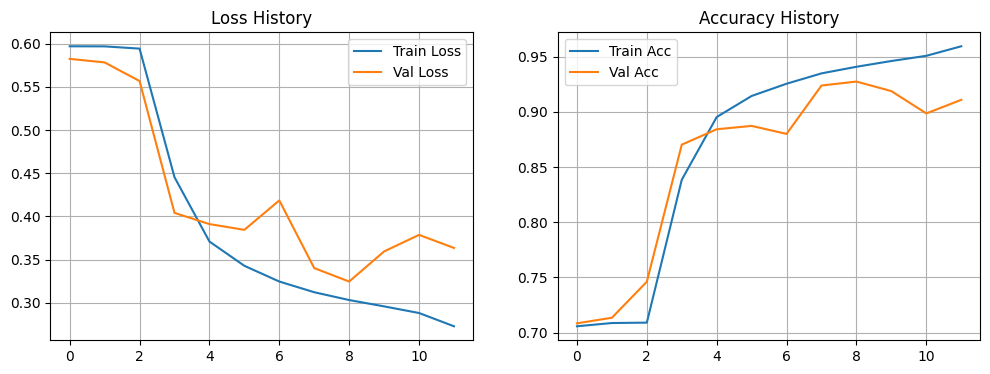

In [10]:
# --- MODEL 3: OPTIMIZED EFFICIENTNET B2 ---

# 1. Data (B2 requires 260x260 resolution for optimal performance)
train_loader_b2, val_loader_b2, _, _ = get_data_loaders(model_img_size=260, use_augmentation=True)

# 2. Model Setup
print("Initializing EfficientNet B2...")
model_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)

# Robust Head
num_features = model_b2.classifier[1].in_features
model_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 2)
)
model_b2 = model_b2.to(DEVICE)

# 3. Execution 
model_b2, hist_b2 = train_smart_strategy(
    model_b2, 
    train_loader_b2, 
    val_loader_b2, 
    model_name="Optimized_B2",
    warmup_epochs=3,
    finetune_epochs=12,
    patience=3
)

### Model 4: Optimized ResNet50

Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
Initializing ResNet50...
🚀 Starting Smart Training for Optimized_ResNet50
Architecture detected: ResNet (using .fc)

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.7232 | Val Acc: 0.8181 | Val Loss: 0.4753
Epoch [2/15] Train Acc: 0.7302 | Val Acc: 0.7886 | Val Loss: 0.5108
Epoch [3/15] Train Acc: 0.7288 | Val Acc: 0.8098 | Val Loss: 0.4802

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.8901 | Val Acc: 0.9295 | Val Loss: 0.3481
Epoch [5/15] Train Acc: 0.9456 | Val Acc: 0.9262 | Val Loss: 0.3574
Epoch [6/15] Train Acc: 0.9606 | Val Acc: 0.9421 | Val Loss: 0.3251
Epoch [7/15] Train Acc: 0.9662 | Val Acc: 0.9602 | Val Loss: 0.2870
Epoch [8/15] Train Acc: 0.9713 | Val Acc: 0.9352 | Val Loss: 0.3721
Epoch [9/15] Train Acc: 0.9737 | Val Acc: 0.9296 | Val Loss: 0.3585
Epoch [10/15] Train Acc: 0.9841 | 

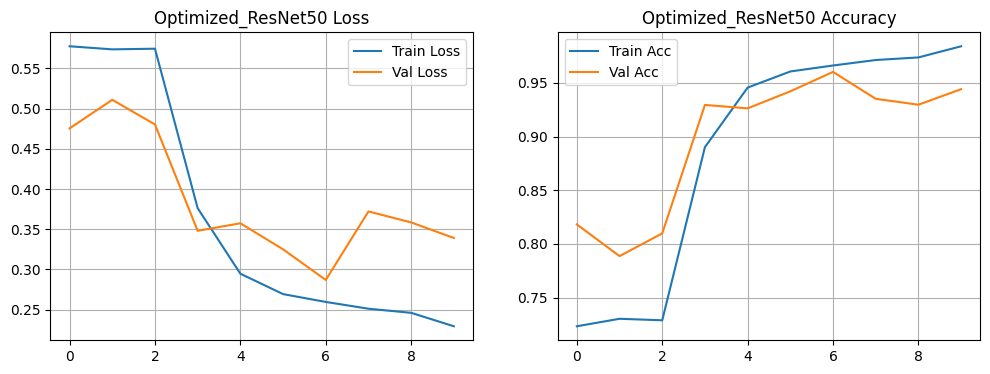

In [15]:
# --- MODEL 4: OPTIMIZED RESNET50 ---

# 1. Data (ResNet standard is 224x224)
train_loader_rn, val_loader_rn, _, _ = get_data_loaders(model_img_size=224, use_augmentation=True)

# 2. Model Setup
print("Initializing ResNet50...")
model_rn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2) # V2 weights are stronger

# ResNet Head Structure is different (model.fc instead of model.classifier)
num_features = model_rn.fc.in_features
model_rn.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 2)
)
model_rn = model_rn.to(DEVICE)

# 3. Execution
# Our function automatically detects "resnet" in the name and unfreezes layer3+layer4
model_rn, hist_rn = train_smart_strategy(
    model_rn, 
    train_loader_rn, 
    val_loader_rn, 
    model_name="Optimized_ResNet50",
    warmup_epochs=3,
    finetune_epochs=12,
    patience=3
)

### Testing Hyper-parameter tuning on dropout of ResNet50

Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
🧪 Starting Dropout Grid Search on: [0.3, 0.4, 0.6, 0.7]


>>> TESTING DROPOUT RATE: 0.3 <<<
🚀 Starting Smart Training for ResNet_Drop_0.3
Architecture detected: ResNet (using .fc)

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.6969 | Val Acc: 0.7721 | Val Loss: 0.5279
Epoch [2/15] Train Acc: 0.7038 | Val Acc: 0.7827 | Val Loss: 0.5164
Epoch [3/15] Train Acc: 0.7054 | Val Acc: 0.8228 | Val Loss: 0.4718

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.8842 | Val Acc: 0.8860 | Val Loss: 0.4263
Epoch [5/15] Train Acc: 0.9350 | Val Acc: 0.9050 | Val Loss: 0.3703
Epoch [6/15] Train Acc: 0.9503 | Val Acc: 0.9113 | Val Loss: 0.3894
Epoch [7/15] Train Acc: 0.9581 | Val Acc: 0.8814 | Val Loss: 0.4788
Epoch [8/15] Train Acc: 0.9636 | Val Acc: 0.9516 | Val Loss: 0.3019
Epoch [9/15] Train Acc: 0.9676 | Val A

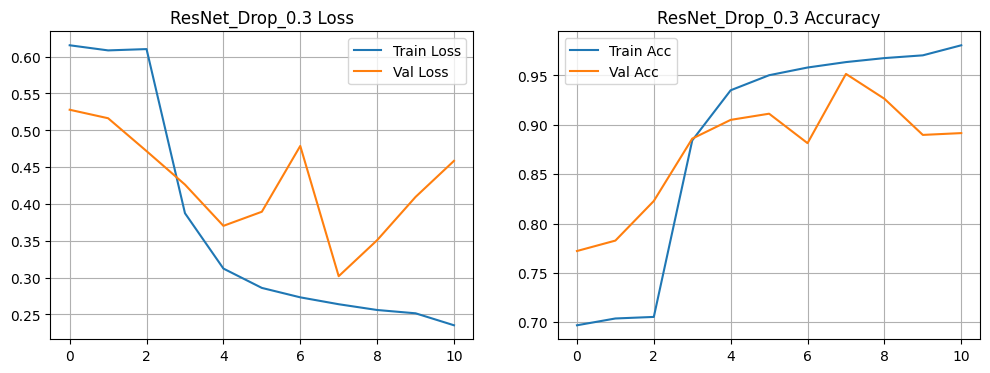

--> Done. Best Val Acc for Dropout 0.3: 0.9516


>>> TESTING DROPOUT RATE: 0.4 <<<
🚀 Starting Smart Training for ResNet_Drop_0.4
Architecture detected: ResNet (using .fc)

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.6889 | Val Acc: 0.6199 | Val Loss: 0.7132
Epoch [2/15] Train Acc: 0.6954 | Val Acc: 0.8076 | Val Loss: 0.4881
Epoch [3/15] Train Acc: 0.6932 | Val Acc: 0.7641 | Val Loss: 0.5399

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.8837 | Val Acc: 0.8773 | Val Loss: 0.4101
Epoch [5/15] Train Acc: 0.9350 | Val Acc: 0.7722 | Val Loss: 0.9506
Epoch [6/15] Train Acc: 0.9495 | Val Acc: 0.8867 | Val Loss: 0.4293
Epoch [7/15] Train Acc: 0.9582 | Val Acc: 0.9071 | Val Loss: 0.4215
Epoch [8/15] Train Acc: 0.9638 | Val Acc: 0.8961 | Val Loss: 0.4413
Epoch [9/15] Train Acc: 0.9664 | Val Acc: 0.9347 | Val Loss: 0.3483
Epoch [10/15] Train Acc: 0.9694 | Val Acc: 0.8997 | Val Loss: 0.4236
Epoch [11/15] Train Acc: 0.9720 | Val Acc: 0.8556 | Val Los

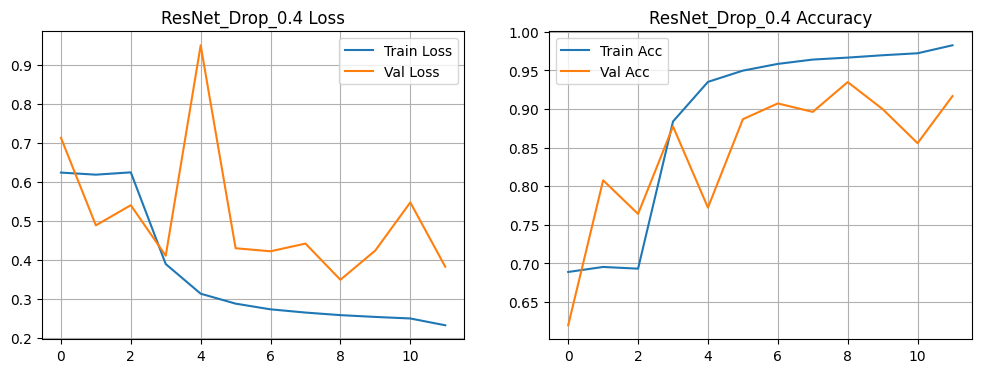

--> Done. Best Val Acc for Dropout 0.4: 0.9347


>>> TESTING DROPOUT RATE: 0.6 <<<
🚀 Starting Smart Training for ResNet_Drop_0.6
Architecture detected: ResNet (using .fc)

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.6627 | Val Acc: 0.7677 | Val Loss: 0.5305
Epoch [2/15] Train Acc: 0.6696 | Val Acc: 0.7880 | Val Loss: 0.5125
Epoch [3/15] Train Acc: 0.6663 | Val Acc: 0.7648 | Val Loss: 0.5294

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.8814 | Val Acc: 0.8904 | Val Loss: 0.3838
Epoch [5/15] Train Acc: 0.9351 | Val Acc: 0.9103 | Val Loss: 0.3724
Epoch [6/15] Train Acc: 0.9493 | Val Acc: 0.8693 | Val Loss: 0.5124
Epoch [7/15] Train Acc: 0.9574 | Val Acc: 0.8913 | Val Loss: 0.3963
Epoch [8/15] Train Acc: 0.9728 | Val Acc: 0.8846 | Val Loss: 0.4547
Early stopping triggered at Epoch 8

Training Complete. Best Val Acc: 0.9103


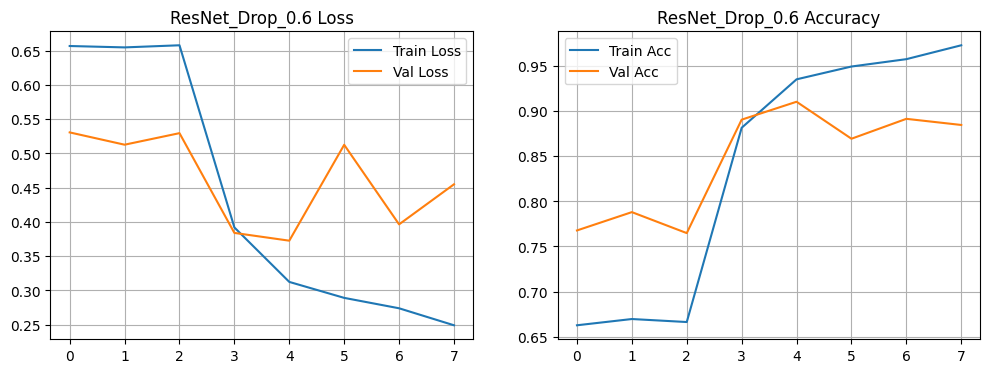

--> Done. Best Val Acc for Dropout 0.6: 0.9103


>>> TESTING DROPOUT RATE: 0.7 <<<
🚀 Starting Smart Training for ResNet_Drop_0.7
Architecture detected: ResNet (using .fc)

=== PHASE 1: WARMUP (Head Only) ===
Epoch [1/15] Train Acc: 0.6474 | Val Acc: 0.7997 | Val Loss: 0.5045
Epoch [2/15] Train Acc: 0.6508 | Val Acc: 0.7241 | Val Loss: 0.5738
Epoch [3/15] Train Acc: 0.6509 | Val Acc: 0.7428 | Val Loss: 0.5627

=== PHASE 2: FINE-TUNING (Unfreezing Backbone) ===
Epoch [4/15] Train Acc: 0.8783 | Val Acc: 0.8305 | Val Loss: 0.5573
Epoch [5/15] Train Acc: 0.9326 | Val Acc: 0.8851 | Val Loss: 0.4531
Epoch [6/15] Train Acc: 0.9479 | Val Acc: 0.9418 | Val Loss: 0.3170
Epoch [7/15] Train Acc: 0.9561 | Val Acc: 0.9328 | Val Loss: 0.3318
Epoch [8/15] Train Acc: 0.9624 | Val Acc: 0.8554 | Val Loss: 0.5932
Epoch [9/15] Train Acc: 0.9767 | Val Acc: 0.8778 | Val Loss: 0.4824
Early stopping triggered at Epoch 9

Training Complete. Best Val Acc: 0.9418


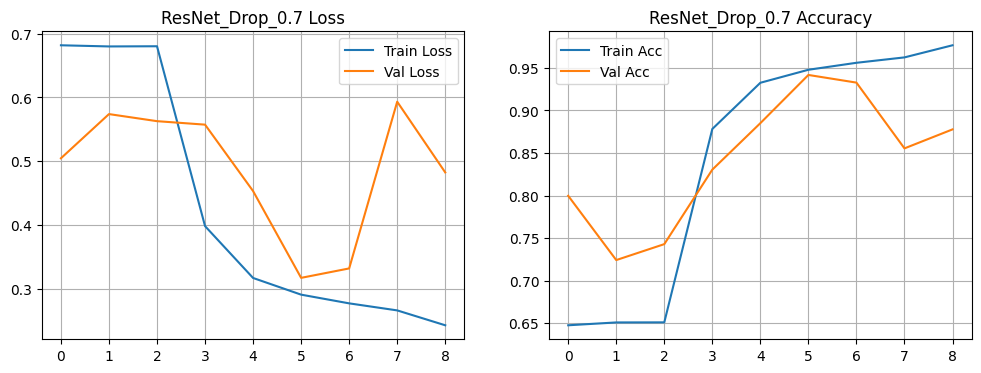

--> Done. Best Val Acc for Dropout 0.7: 0.9418

   DROPOUT SEARCH RESULTS   
Dropout    | Best Val Acc   
------------------------------
0.5        | 0.9602 (96.02%)
0.3        | 0.9516 (95.16%)
0.7        | 0.9418 (94.18%)
0.4        | 0.9347 (93.47%)
0.6        | 0.9103 (91.03%)
🏆 WINNER: Dropout 0.5 with 96.02%


In [8]:
# --- DROPOUT HYPERPARAMETER SEARCH ---

# 1. Define the parameters to test
# We skip 0.5 as you already have results for it
dropout_rates = [0.3, 0.4, 0.6, 0.7] 

# Dictionary to store the best accuracy for each dropout rate
results = {}

# Data (ResNet standard is 224x224)
train_loader_rn, val_loader_rn, _, _ = get_data_loaders(model_img_size=224, use_augmentation=True)

print(f"🧪 Starting Dropout Grid Search on: {dropout_rates}")
print("="*60)

for p in dropout_rates:
    print(f"\n\n>>> TESTING DROPOUT RATE: {p} <<<")
    
    # 2. Re-Initialize a FRESH ResNet50 for every iteration
    # Crucial: We must wipe the weights clean to ensure a fair test
    model_search = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # 3. Apply the specific Dropout Rate
    num_ftrs = model_search.fc.in_features
    model_search.fc = nn.Sequential(
        nn.Dropout(p=p),  # <--- Variable Dropout Here
        nn.Linear(num_ftrs, 2)
    )
    
    model_search = model_search.to(DEVICE)
    
    # 4. Train using the Smart Strategy
    # We use 'train_loader_rn' and 'val_loader_rn' (ResNet specific loaders)
    # Ensure these variables exist from your previous cells
    _, history = train_smart_strategy(
        model_search, 
        train_loader_rn,
        val_loader_rn,
        model_name=f"ResNet_Drop_{p}",
        warmup_epochs=3,
        finetune_epochs=12,
        patience=3 # Aggressive stopping to save time
    )
    
    # 5. Log the Best Validation Accuracy
    best_acc = max(history['val_acc'])
    results[p] = best_acc
    print(f"--> Done. Best Val Acc for Dropout {p}: {best_acc:.4f}")


previous_result_05 = 0.9602
results[0.5] = previous_result_05

# --- FINAL REPORT ---
print("\n" + "="*30)
print("   DROPOUT SEARCH RESULTS   ")
print("="*30)
print(f"{'Dropout':<10} | {'Best Val Acc':<15}")
print("-" * 30)

# Sort by accuracy descending (Best on top)
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

for p, acc in sorted_results.items():
    print(f"{p:<10} | {acc:.4f} ({acc*100:.2f}%)")

best_dropout = list(sorted_results.keys())[0]
print("="*30)
print(f"🏆 WINNER: Dropout {best_dropout} with {sorted_results[best_dropout]*100:.2f}%")

### 6 - Testing & Evaluation

In [19]:
# --- EVALUATION ON TEST SET ---
def evaluate_model(model, test_loader, device=DEVICE, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # For AUC
    
    print(f"Evaluating {model_name} on Test Set...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            # Get Probabilities (Softmax)
            probs = torch.softmax(outputs, dim=1)[:, 1] # Probability of Class 1 (Deepfake)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1-Score": f1,
        "AUC": auc,
        "Confusion Matrix": cm
    }

In [20]:
# 1. Setup Test Loader (Basic Transforms only!)
# Note: We create one loader per image size needed
_, _, test_loader_224, _ = get_data_loaders(model_img_size=224, use_augmentation=False)
_, _, test_loader_260, _ = get_data_loaders(model_img_size=260, use_augmentation=False)

results = []

# List of models to evaluate
# Structure: (Model Object, Model Name, Specific Loader)
models_to_test = [
    (model_b0_base, "Baseline_B0", test_loader_224),
    (model_b0_opt,  "Optimized_B0", test_loader_224),
    (model_b2,      "Optimized_B2", test_loader_260),
    (model_rn,      "Optimized_ResNet50", test_loader_224)
]

for model, name, loader in models_to_test:
    res = evaluate_model(model, loader, model_name=name)
    results.append(res)

Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
Evaluating Baseline_B0 on Test Set...


Testing Baseline_B0: 100%|██████████| 341/341 [00:23<00:00, 14.26it/s]


Evaluating Optimized_B0 on Test Set...


Testing Optimized_B0: 100%|██████████| 341/341 [00:23<00:00, 14.52it/s]


Evaluating Optimized_B2 on Test Set...


Testing Optimized_B2: 100%|██████████| 341/341 [00:32<00:00, 10.59it/s]


Evaluating Optimized_ResNet50 on Test Set...


Testing Optimized_ResNet50: 100%|██████████| 341/341 [00:31<00:00, 10.94it/s]



=== FINAL LEADERBOARD ===


,Model,Accuracy,F1-Score,AUC
2,Optimized_B2,0.927719,0.927552,0.987387
3,Optimized_ResNet50,0.959129,0.960363,0.986238
1,Optimized_B0,0.897594,0.895256,0.975318
0,Baseline_B0,0.702976,0.612230,0.967343


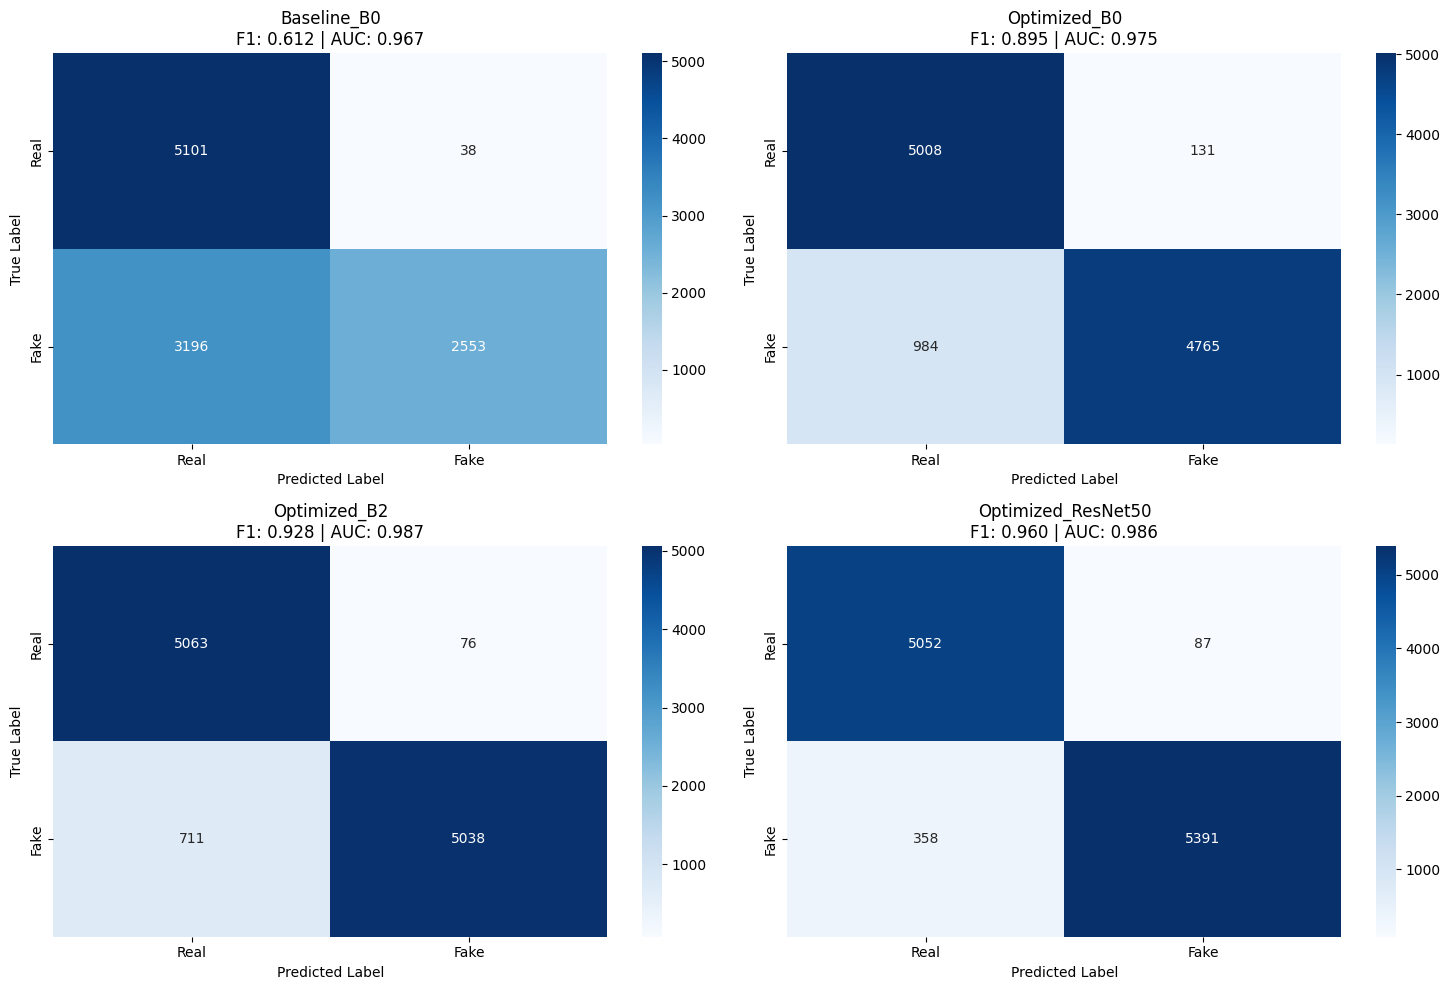

In [21]:
# 1. Create DataFrame
df_results = pd.DataFrame(results)
# Drop CM for the table view (it's too big)
display_df = df_results.drop(columns=["Confusion Matrix"])

print("\n=== FINAL LEADERBOARD ===")
display(display_df.sort_values(by="AUC", ascending=False))

# 2. Visualize Confusion Matrices
plt.figure(figsize=(15, 10))
for i, res in enumerate(results):
    plt.subplot(2, 2, i+1)
    sns.heatmap(res["Confusion Matrix"], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f"{res['Model']}\nF1: {res['F1-Score']:.3f} | AUC: {res['AUC']:.3f}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

🔄 Generating Test Loader...
Train samples:   90409 (Used for learning weights)
Val samples:   10888   (Used for tuning/stopping)
Test samples:   10888   (Used for final metric)
✅ Model loaded: Optimized_Resnet50.pth
🔍 Scanning Test Set for 5 Real and 5 Fake images...


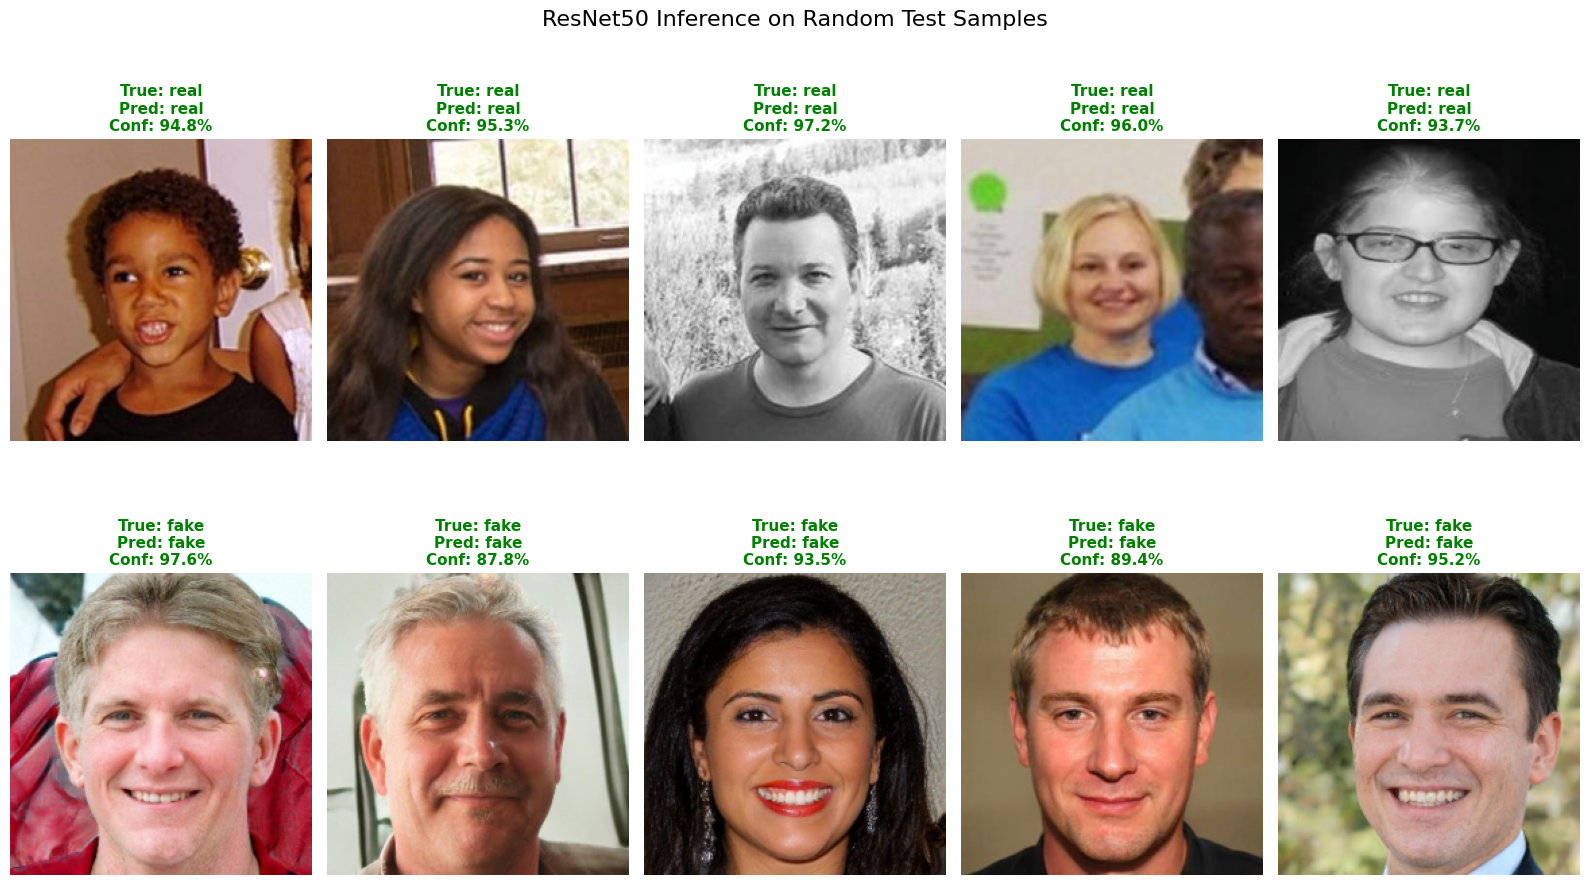

In [20]:
# --- VISUALIZATION OF PREDICTIONS ON TEST SAMPLES ---

# --- 1. SETUP DATA LOADER ---
print("🔄 Generating Test Loader...")
# Ensure we get the loader for 224x224 images
_, _, test_loader_224, class_names = get_data_loaders(model_img_size=224, use_augmentation=False)

# --- 2. LOAD THE SPECIFIC MODEL ---
MODEL_PATH = "Optimized_Resnet50.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create architecture
model_viz = models.resnet50(weights=None)
num_ftrs = model_viz.fc.in_features

# Define fc as Sequential to match the saved weights (Dropout -> Linear)
model_viz.fc = nn.Sequential(
    nn.Dropout(0.5),        
    nn.Linear(num_ftrs, 2)  
)

# Load weights
try:
    model_viz.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model_viz.to(device)
    model_viz.eval()
    print(f"✅ Model loaded: {MODEL_PATH}")
except RuntimeError as e:
    print(f"❌ Error loading model: {e}")

# --- 3. GATHER SAMPLES ---
real_samples = []
fake_samples = []
needed = 5

print("🔍 Scanning Test Set for 5 Real and 5 Fake images...")

with torch.no_grad():
    for inputs, labels in test_loader_224: 
        if len(real_samples) >= needed and len(fake_samples) >= needed:
            break
            
        for i in range(len(labels)):
            label_idx = labels[i].item()
            class_name = class_names[label_idx]
            
            if "real" in class_name.lower() and len(real_samples) < needed:
                real_samples.append((inputs[i], label_idx))
            elif "fake" in class_name.lower() and len(fake_samples) < needed:
                fake_samples.append((inputs[i], label_idx))

viz_samples = real_samples + fake_samples

# --- 4. VISUALIZATION ---
def show_sample(img_tensor, ax, true_idx, pred_idx, conf):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    true_txt = class_names[true_idx]
    pred_txt = class_names[pred_idx]
    color = 'green' if true_idx == pred_idx else 'red'
    
    # Title with padding
    ax.set_title(f"True: {true_txt}\nPred: {pred_txt}\nConf: {conf:.1%}", 
                 color=color, fontsize=11, fontweight='bold')
    ax.axis('off')

if not viz_samples:
    print("⚠️ No samples found.")
else:
    # INCREASED FIGURE HEIGHT HERE
    fig, axes = plt.subplots(2, 5, figsize=(16, 10)) 
    fig.suptitle("ResNet50 Inference on Random Test Samples", fontsize=16)
    axes = axes.flatten()

    for i, (img, true_label) in enumerate(viz_samples):
        input_tensor = img.unsqueeze(0).to(device)
        output = model_viz(input_tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        
        show_sample(img, axes[i], true_label, pred.item(), conf.item())

    plt.tight_layout()
    plt.show()